# Three-Dimensional ECM Plots
Make 3D plots of ALHIC1901 228_4 and 230_4

## Import Data

In [29]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
#%matplotlib tk
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section

## Setup

In [30]:
# Set filepaths

path_to_data = '../../data/ecm/alligned/'
path_to_figures = '../../../figures/'

In [31]:
# smoothing window
window = 10

## Load Data

In [32]:
# Load metadata
meta = pd.read_csv(path_to_data + 'metadata.csv')
meta.head()

,core,time,section,face,ACorDC,Y_left,Y_right,AC_edgespace,DC_edgespace
0,alhic1901,-,230_4,t,DC,-5.080,206.763,15,10
1,alhic1901,-,230_4,l,DC,70.404,170.096,15,10
2,alhic1901,-,228_4,t,DC,-10.000,192.000,15,10
3,alhic1901,-,228_4,l,AC,63.881,166.250,15,10
4,alhic1901,-,228_4,l,DC,65.891,149.177,15,10


In [33]:
# Load ECM data

data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    if ACorDC == 'AC':

        data_item = ECM(core,section,face,ACorDC,path_to_data=path_to_data)
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item.rem_ends(15)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)

Processing data:  29%|██▊       | 4/14 [00:00<00:00, 24.29it/s]

Reading alhic1901, section 228_4-l-AC
Reading alhic1901, section 230_4-l-AC
Reading alhic1901, section 230_4-t-AC


Processing data:  64%|██████▍   | 9/14 [00:01<00:00,  7.48it/s]

Reading alhic1901, section 230_4-r-AC
Reading alhic1901, section 228_4-r-AC


Processing data:  79%|███████▊  | 11/14 [00:01<00:00,  8.72it/s]

Reading alhic1901, section 228_4-t-AC
Reading alhic1901, section 228_4-o-AC


Processing data: 100%|██████████| 14/14 [00:01<00:00,  7.16it/s]


In [34]:
# Put ECM data into core_section structure

s228_4 = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4 = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4,s230_4]:
    s.add_3d_coords()

No data found for opposite face of section 230_4 in core alhic1901
The 'opposite' face does not exist for this core section.


In [35]:
print(s228_4.left.y_left)
print(s228_4.left.y_right)

63.881
166.25


## Make 3D Plot




In [36]:
# setup

# colormap
cmap = matplotlib.colormaps['Spectral']

# fontsize
fsz = 12

In [37]:
# make function to draw outline
def draw_outline(radius, d_min, d_max, ax, leftorright):
    
    angle_resolution = 50
    
    # Generate points in the xz-plane (side surface)
    if leftorright=='left':
        theta = np.linspace(1*np.pi/2, 2*np.pi / 2, angle_resolution)
    elif leftorright=='right':
        theta = np.linspace(0*np.pi/2, 1*np.pi / 2, angle_resolution)
    else:
        print("Error - invalid input to drawoutline function")
        
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    
    # set sign of outlying points
    if leftorright=='left':
        r=-radius
    elif leftorright=='right':
        r=radius
    else:
        print("Error - invalid input to drawoutline function")

    # Plot the front side curve
    ax.plot(x, d_max * np.ones_like(x), z, color='k')
    # Plot the back side curve
    ax.plot(x, d_min*np.ones_like(x), z, color='k')
    # Plot the Bottom Edge
    ax.plot([0,0],[d_min, d_max],[radius,radius],color='k')
    # Plot the Top Edge
    ax.plot([0,0],[d_min, d_max],[0,0],color='k')
    # Plot the Ouside Edge
    ax.plot([r,r],[d_min, d_max],[0,0],color='k')
    # plot the front edge
    ax.plot([r,0],[d_min, d_min],[0,0],color='k')
    # plot the back edge
    ax.plot([r,0],[d_max, d_max],[0,0],color='k')
    # plot the front upright edge
    ax.plot([0,0],[d_max, d_max],[0,radius],color='k')
    # plot the back upright edge
    ax.plot([0,0],[d_min, d_min],[0,radius],color='k')



Running section 228_4
    Running face t
    Running face l


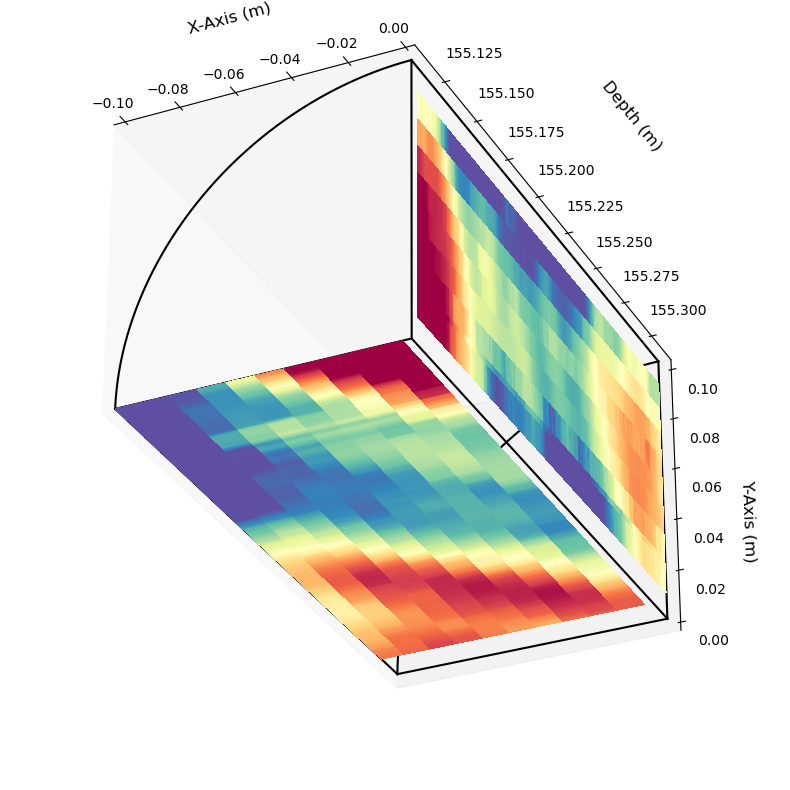

    Running face t
    Running face r


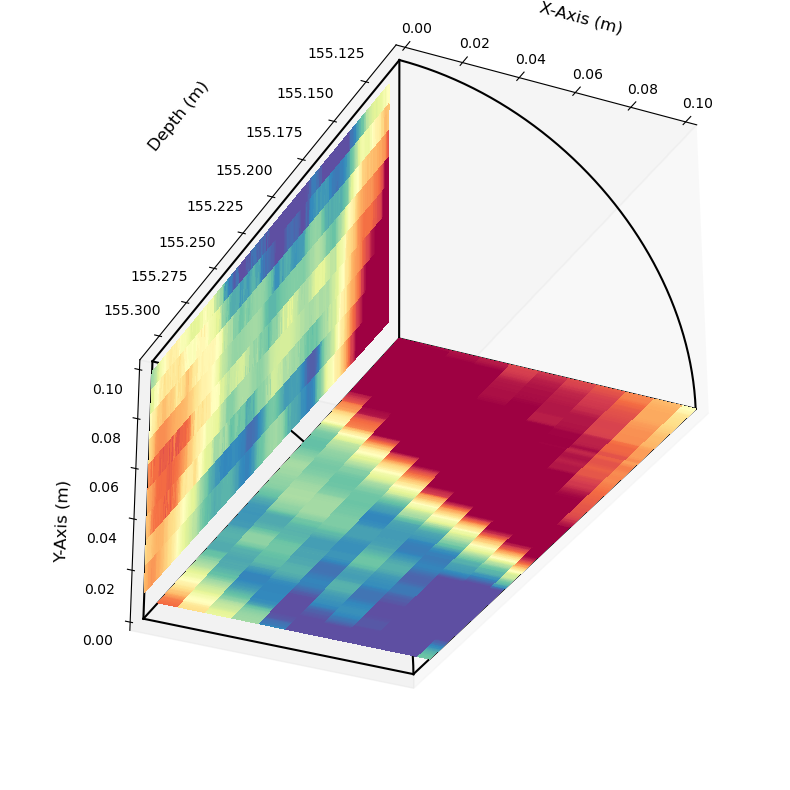

Running section 230_4
    Running face t
    Running face l


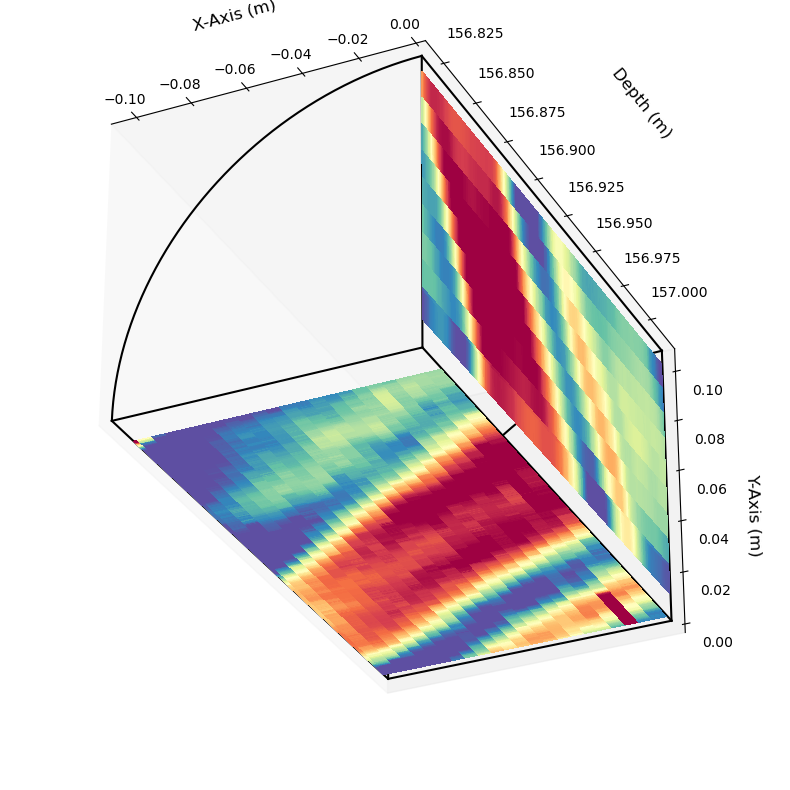

    Running face t
    Running face r


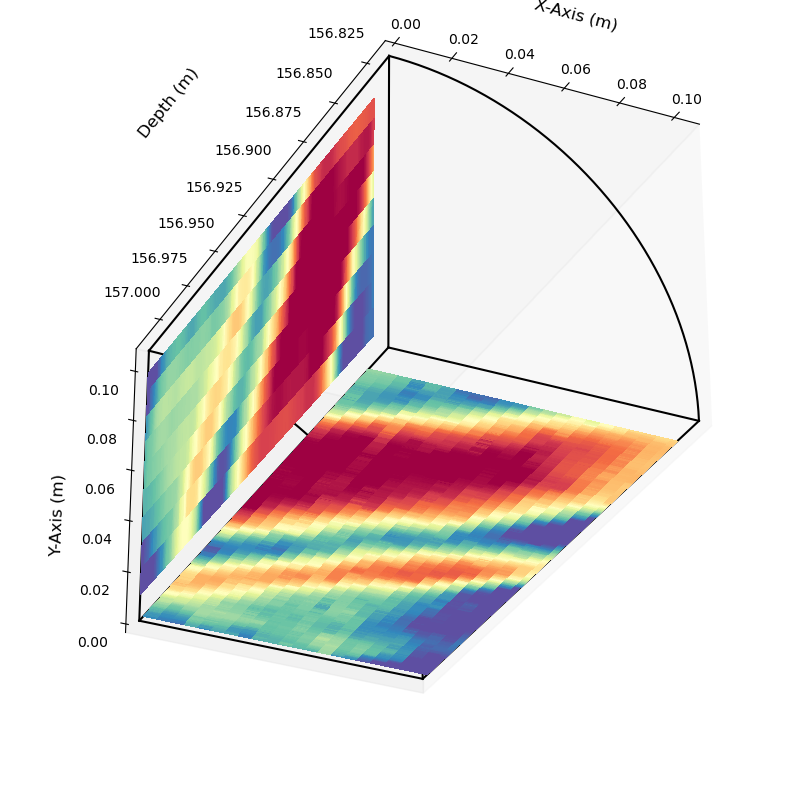

In [38]:
# loop through sections
for s in [s228_4,s230_4]:

    print("Running section "+s.section)

    if s.core == '228_4':

        # make colorscale
        meas_all = np.concatenate((s.top.meas, s.left.meas, s.right.meas, s.opposite.meas)) 
        pltmin = np.percentile(meas_all,10)
        pltmax = np.percentile(meas_all,90)
        rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

        # Define the parameters for the quarter cylinder
        radius = max([max(abs(s.top.x_3d)),max(abs(s.left.y_3d)),max(abs(s.right.y_3d)),max(abs(s.opposite.y_3d))])

        # get min and max depth accross all faces
        d_min = min([min(s.left.depth_s),
                        min(s.top.depth_s),
                        min(s.right.depth_s),
                        min(s.opposite.depth_s)])
        d_max = max([max(s.left.depth_s),
                        max(s.top.depth_s),
                        max(s.right.depth_s),
                        max(s.opposite.depth_s)])
    
    else:

        # make colorscale
        meas_all = np.concatenate((s.top.meas, s.left.meas, s.right.meas)) 
        pltmin = np.percentile(meas_all,10)
        pltmax = np.percentile(meas_all,90)
        rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

        # Define the parameters for the quarter cylinder
        radius = max([max(abs(s.top.x_3d)),max(abs(s.left.y_3d)),max(abs(s.right.y_3d))])

        # get min and max depth accross all faces
        d_min = min([min(s.left.depth_s),
                        min(s.top.depth_s),
                        min(s.right.depth_s)])
        d_max = max([max(s.left.depth_s),
                        max(s.top.depth_s),
                        max(s.right.depth_s)])

    for side in ['left','right']:

        # make figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect([1,1,1])

        # draw outline
        draw_outline(radius,d_min,d_max,ax,side)

        # let's plot ECM data
        if side == 'right':
            faces = [s.top,s.right]
            face_names = ['t','r']
        else:
            faces = [s.top,s.left]
            face_names = ['t','l']

        # loop through and plot each face
        for f,n in zip(faces,face_names):

            print("    Running face "+n)

            for i in range(len(f.y_vec)):

                # get data from this track
                meas = f.meas_s[f.y_s==f.y_vec[i]]
                depth = f.depth_s[f.y_s==f.y_vec[i]]
                x_3d = f.x_3d[f.y_s==f.y_vec[i]]
                y_3d = f.y_3d[f.y_s==f.y_vec[i]]

                # exclude face data from other top
                if not (n == 't' and ((side == 'left' and x_3d[0] > 0) or (side == 'right' and x_3d[0] < 0))):
                
                    if n=='t':
                        z = [0,0,0,0]
                    else:
                        x=[0,0,0,0]

                    if n == 't':
                        if side == 'left':
                            x_lo = x_3d[0] - f.y_space/2000
                            if x_lo < -radius:
                                x_lo = -radius
                            x_hi = x_3d[0] + f.y_space/2000
                            if x_hi > 0:
                                x_hi = 0
                        else:
                            x_lo = x_3d[0] - f.y_space/2000
                            if x_lo < 0:
                                x_lo = 0
                            x_hi = x_3d[0] + f.y_space/2000
                            if x_hi > radius:
                                x_hi = radius

                        x = [x_lo,x_lo,x_hi,x_hi]
                        z = [0,0,0,0]
                    else:

                        y_lo = y_3d[0] - f.y_space/2000
                        if y_lo < 0:
                            y_lo = 0
                        y_hi = y_3d[0] + f.y_space/2000
                        if y_hi > radius:
                            y_hi = radius
                        
                        z = [y_lo,y_lo,y_hi,y_hi]
                        x = [0,0,0,0]
   
                        
                    for j in range(len(meas)-1):

                        #
                        # if n=='t':
                        #     x = [x_3d[j]-f.y_space/2000,x_3d[j]-f.y_space/2000,x_3d[j]+f.y_space/2000,x_3d[j]+f.y_space/2000]
                        # else:
                        #     z= [y_3d[j]-f.y_space/2000,y_3d[j]-f.y_space/2000,y_3d[j]+f.y_space/2000,y_3d[j]+f.y_space/2000]

                        y = [depth[j],depth[j+1],depth[j+1],depth[j]]

                        verts = [list(zip(x,y,z))]
                        collection = Poly3DCollection(verts, alpha=1,antialiased=False)
                        face_color = cmap(rescale(meas[j]))
                        collection.set_facecolor(face_color)
                        ax.add_collection3d(collection)


        # set labels
        ax.set_ylabel('Depth (m)',fontsize=fsz,labelpad=60)
        ax.set_xlabel('X-Axis (m)',fontsize=fsz, labelpad=10)
        ax.set_zlabel('Y-Axis (m)',fontsize=fsz, labelpad=20,rotation=0)

        ax.tick_params(axis='z', pad=10)
        ax.tick_params(axis='y', pad=20)

        # set axis limits
        ax.set_zlim(-0.001,radius)
        ax.set_ylim(d_min,d_max)

        # plot housekeeping
        #fig.suptitle(s.core + ' ' + s.section + ' ' + side)

        # set perspective
        if side=='left':
            ax.view_init(elev=-30, azim=-65,roll=0)
            ax.set_xlim(-radius,0.001) 
        if side=='right':
            ax.view_init(elev=-30, azim=-115,roll=0)
            ax.set_xlim(-0.001,radius)

        # set to scale
        ax.set_aspect('equal')

        # turn of the background grid
        #ax.xaxis.pane.fill = False
        #ax.yaxis.pane.fill = False
        #ax.zaxis.pane.fill = False
        #ax.xaxis.pane.set_edgecolor('black')
        #ax.yaxis.pane.set_edgecolor('black')
        #ax.zaxis.pane.set_edgecolor('black')
        ax.grid(False)
        #ax.w_xaxis.line.set_color((1,1,1,0))
        #ax.w_yaxis.line.set_color((1,1,1,0))
        #ax.w_zaxis.line.set_color((1,1,1,0))
        # set the ticks


        plt.show()

    

# Now let's plot the opposite (bottom half) of the cylinder for 228_4 only



In [39]:
# make function to draw outline
def draw_outline_bot(radius, d_min, d_max, ax, leftorright):
    
    angle_resolution = 50
    
    # Generate points in the xz-plane (side surface)
    theta = np.linspace(np.pi+0.04150569204, 2* np.pi-0.04150569204, angle_resolution)
        
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    
    r = radius


    # Plot the front side curve
    ax.plot(x, d_max * np.ones_like(x), z, color='k')
    # Plot the back side curve
    ax.plot(x, d_min*np.ones_like(x), z, color='k')


    # Plot the left Edge
    ax.plot([-r,-r],[d_min, d_max],[0,0],color='k')

    # Plot the Ouside Edge
    ax.plot([r,r],[d_min, d_max],[0,0],color='k')

    # plot the front edge
    ax.plot([r,-r],[d_min, d_min],[0,0],color='k')

    # plot the back edge
    ax.plot([r,-r],[d_max, d_max],[0,0],color='k')


    Running face opposite


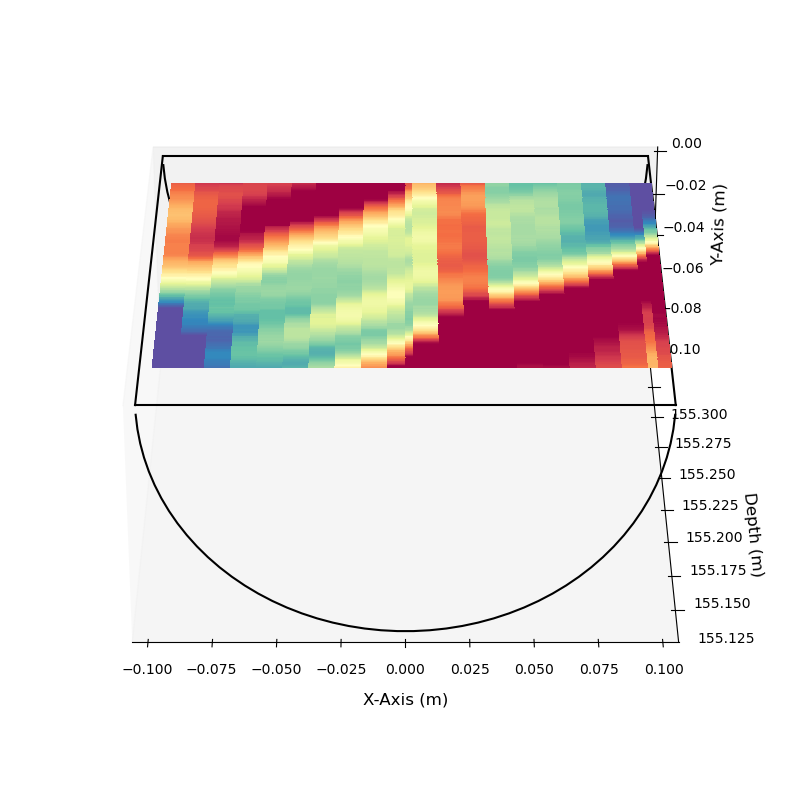

In [40]:
# loop through sections
s = s228_4
side = 'opposite'

# make colorscale
meas_all = np.concatenate((s.top.meas, s.left.meas, s.right.meas, s.opposite.meas)) 
pltmin = np.percentile(meas_all,10)
pltmax = np.percentile(meas_all,90)
rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

# Define the parameters for the quarter cylinder
radius = max([max(abs(s.top.x_3d)),max(abs(s.left.y_3d)),max(abs(s.right.y_3d)),max(abs(s.opposite.y_3d))])

# get min and max depth accross all faces
d_min = min([min(s.left.depth_s),
                min(s.top.depth_s),
                min(s.right.depth_s),
                min(s.opposite.depth_s)])
d_max = max([max(s.left.depth_s),
                max(s.top.depth_s),
                max(s.right.depth_s),
                max(s.opposite.depth_s)])

# make figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

# draw outline
draw_outline_bot(radius,d_min,d_max,ax,side)

f = s.opposite
n = 'opposite'

print("    Running face "+n)

for i in range(len(f.y_vec)):

    # get data from this track
    meas = f.meas_s[f.y_s==f.y_vec[i]]
    depth = f.depth_s[f.y_s==f.y_vec[i]]
    x_3d = f.x_3d[f.y_s==f.y_vec[i]]
    y_3d = f.y_3d[f.y_s==f.y_vec[i]]

    # exclude face data from other top
    if not (n == 't' and ((side == 'left' and x_3d[0] > 0) or (side == 'right' and x_3d[0] < 0))):
    
        z = [0,0,0,0]

        x_lo = x_3d[0] - f.y_space/2000
        if x_lo < 0:
            x_lo = 0
        x_hi = x_3d[0] + f.y_space/2000
        if x_hi > radius:
            x_hi = radius

        x = [x_lo,x_lo,x_hi,x_hi]
            
        for j in range(len(meas)-1):

            #
            # if n=='t':
            #     x = [x_3d[j]-f.y_space/2000,x_3d[j]-f.y_space/2000,x_3d[j]+f.y_space/2000,x_3d[j]+f.y_space/2000]
            # else:
            #     z= [y_3d[j]-f.y_space/2000,y_3d[j]-f.y_space/2000,y_3d[j]+f.y_space/2000,y_3d[j]+f.y_space/2000]

            y = [depth[j],depth[j+1],depth[j+1],depth[j]]

            verts = [list(zip(x,y,z))]
            collection = Poly3DCollection(verts, alpha=1,antialiased=False)
            face_color = cmap(rescale(meas[j]))
            collection.set_facecolor(face_color)
            ax.add_collection3d(collection)

# set labels
ax.set_ylabel('Depth (m)',fontsize=fsz,labelpad=30)
ax.set_xlabel('X-Axis (m)',fontsize=fsz, labelpad=10)
ax.set_zlabel('Y-Axis (m)',fontsize=fsz, labelpad=20,rotation=0)

ax.tick_params(axis='z', pad=10)
ax.tick_params(axis='y', pad=20)

# set axis limits
ax.set_zlim(-radius,0)
ax.set_ylim(d_min,d_max)

# plot housekeeping
#fig.suptitle(s.core + ' ' + s.section + ' ' + side)

# set perspective
ax.view_init(elev=30, azim=-90,roll=0)
ax.set_xlim(-radius,radius)

# set to scale
ax.set_aspect('equal')
ax.grid(False)


plt.show()
